In [1]:
#################

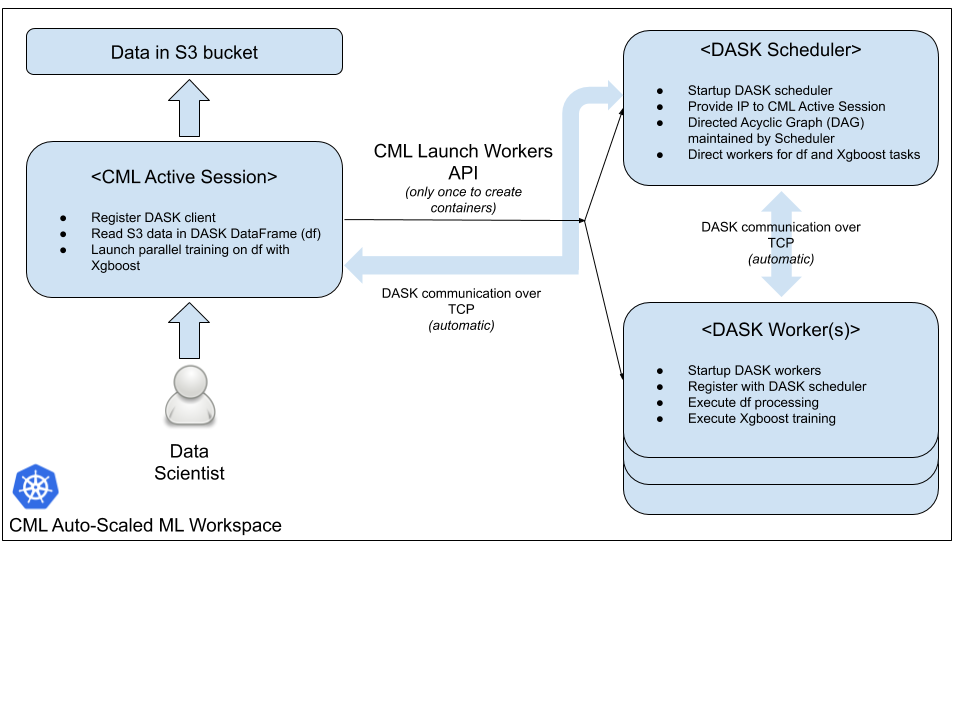

In [2]:
# defined as global
daskschurl = ""

In [3]:
import cdsw
import os
import time

def dask_distributed_launch(nworkers=1,ncpu=2,nmemory=4):
    # modify global copy
    global daskschurl
    
    #check if already running
    if daskschurl!="":
        #print(cdsw.list_workers())
        print(" Dask Scheduler Already Launched " + daskschurl)
        return(daskschurl)
    
    # Launch CDSW workers. These are engines that will run in 
    # the same project, execute a given code or script, and exit.
    # Scheduler engine will keep running in background until session is closed
    dask_scheduler = cdsw.launch_workers(n=1, cpu=2, memory=4, 
                                  kernel="python3",script="daskschedular.py")


    # IP of launched container comes up unknown for a while
    # Wait for a while so IP is available in data structure
    time.sleep(30)

    # Get schedular IP
    schedulerid = dask_scheduler[0]["id"]
    listtemp = cdsw.list_workers()

    for x in listtemp:
      if x["id"] == schedulerid:
        schedulerip = x["ip_address"]


    print(" Scheduler IP: " + schedulerip)

    #Scheduler protocol and port - defaults from Dask
    schproto = "tcp://"
    schport = ":8786"

    schloc = schproto + schedulerip + schport
    print(" Scheduler URL: " + schloc)

    dask_client = []
    # Launch at least one Dask Worker
    for c in range(nworkers):
        dask_client = dask_client + cdsw.launch_workers(n=1, cpu=ncpu, memory=nmemory, 
                                  kernel="python3",script="daskworker.py",
                                      env={"DASKSCHURL": schloc})

        # wait for a while until the container is launched successfully
        time.sleep(10)
    
    #set scheduler URL as environment variable
    #os.putenv("DASKSCHURL", schloc)
    daskschurl = schloc

    #return scheduler URL
    return(schloc)


def dask_stop_workers():
    global daskschurl
    cdsw.stop_workers()
    daskschurl = ""
    

In [4]:
def dask_test():
    from dask.distributed import Client
    client = Client(daskschurl)
    import dask.array as da
    x = da.random.random((40000,40000),chunks=(1000,1000))
    y = da.exp(x).sum()
    print(" Result of DASK distributed array test: " + str(y.compute()) + "\n")


In [5]:
def dask_read_scheduler_file(fname="dasklog.txt"):
    import json
    with open("dasklog.txt","r") as jfile:
        schfile = json.load(jfile)
    return(schfile["address"])

In [6]:
#stop any previous dask distributed containers
dask_stop_workers()

In [7]:
#launch scheduler and worker container(s) - you can specify number of workers as argument
#to relaunch - first call dask_stop_workers() and then call this again
dask_distributed_launch(2,1,2)

 Scheduler IP: 100.66.0.37
 Scheduler URL: tcp://100.66.0.37:8786


'tcp://100.66.0.37:8786'

In [8]:
#check if global variable has the right URL
#we will use this to register a client
print(daskschurl)

tcp://100.66.0.37:8786


In [9]:
import pandas as pd
import cdsw
#any previously stopped pods may show up with status failed
#we are not showing those
workers_list = cdsw.list_workers()
print(" === List of launched running pods === ")
print(" ===      (scheduler + workers)    === ")

#collect relevant fields
workersl = []
for l in workers_list:
    #print(l)
    #print(" id: " + l["id"] + " IP Addr: " + l["ip_address"] + " CPUs: " + str(l["cpu"]) + " Memory: " + str(l["memory"]) \
    #     + " Status: " + l["status"])
    workersl = workersl + [[l["id"],l["ip_address"],l["cpu"],l["memory"],l["status"]]]

workersactive = pd.DataFrame(workersl,columns=["Id","IP Address","CPUs","Memory","Status"])
print(workersactive[workersactive.Status=="running"])

 === List of launched running pods === 
 ===      (scheduler + workers)    === 
                 Id   IP Address  CPUs  Memory   Status
1  jjyfxitootszczns  100.66.0.38     1       2  running
2  gvyfrcjkjjl70msx  100.66.0.37     2       4  running


In [10]:
%%time
#check distributed dask is working
dask_test()

#Register a DASK client and run a test
#from dask.distributed import Client
#client = Client(daskschurl)
#import dask.array as da
#x = da.random.random((40000,40000),chunks=(1000,1000))
#y = da.exp(x).sum()
#print("DASK test result: ") 
#print(y.compute())

 Result of DASK distributed array test: 2749281211.2986207

CPU times: user 7.72 s, sys: 123 ms, total: 7.84 s
Wall time: 14.2 s


In [11]:
%%time
#Register a client to DASK
from dask.distributed import Client
client = Client(daskschurl)

CPU times: user 5.9 ms, sys: 2 ms, total: 7.9 ms
Wall time: 56.7 ms


In [12]:
import dask.dataframe as dd
import pandas as pd

url="https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
header_list = ["target","alcohol", "malic_acid", "ash","alcalinity_of_ash","magnesium","total_phenols","flavanoids","nonflavanoid_phenols","proanthocyanins","color_intensity","hue","od280/od315_of_diluted_wines","proline"]
df=dd.read_csv(url,names=header_list)


In [13]:
df

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
npartitions=1,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [14]:
#check number of partitions 

df.known_divisions
df.set_index("proline")
df = df.repartition(npartitions=10)
df.npartitions


10

In [15]:
#DASK also implements lazy computations - so a compute() asks it to return output
df.describe().compute()

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.420000,1.730000,2.292500,18.000000,92.000000,1.885000,1.327500,0.295000,1.350000,3.287500,0.817500,2.005000,549.000000
50%,2.000000,13.400000,2.137500,2.430000,20.750000,100.500000,2.492500,2.325000,0.385000,1.670000,5.587500,1.050000,3.000000,699.000000
75%,3.000000,14.370000,4.065000,2.650000,23.750000,113.750000,3.075000,3.320000,0.567500,2.290000,9.670000,1.310000,3.572500,1320.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [16]:
df.head()

,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [17]:
df.target.unique()

Dask Series Structure:
npartitions=1
    int64
      ...
Name: target, dtype: int64
Dask Name: unique-agg, 37 tasks

In [18]:
#Use the wine dataset

#Target
dt=df["target"]

#Features
df1=df.drop(columns=["target"])

#print a few lines
print("\n Dataframe: ")
print(df1.head())

#print target classes example
print("\n Target: ")
print(dt.head())      





 Dataframe: 
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6        127           2.80   
1    13.20        1.78  2.14               11.2        100           2.65   
2    13.16        2.36  2.67               18.6        101           2.80   
3    14.37        1.95  2.50               16.8        113           3.85   
4    13.24        2.59  2.87               21.0        118           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0    

In [19]:
%%time
# train and test split
from dask_ml.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(df1,dt,random_state=123)      
      
#xgboost
from dask_ml.xgboost import XGBClassifier
est = XGBClassifier(num_class=4)      
      
#fit model      
model = est.fit(train, train_labels)


/usr/local/lib/python3.6/site-packages/dask_ml/model_selection/_split.py:469: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  category=FutureWarning,


CPU times: user 361 ms, sys: 45.9 ms, total: 407 ms
Wall time: 3.73 s


In [20]:
#which features contribute most
#get feature importance in a pandas dataframe
import pandas as pd
featureimp = pd.DataFrame(model.feature_importances_)
featureimp.columns = ['classifier_feature_importance']
featureimp["variable"] = df1.columns
print("\n\n === Xgboost Classifier Feature Importance: === ")
print(featureimp.sort_values(by="classifier_feature_importance", ascending=False))
#featureimp.to_csv()


#predictions
ypred = model.predict(test)

#sample some predictions
#print("\n Sample initial five predictions: ")      
#print(ypred[[1,2,3]].compute())
      
#check accuracy on test set      
from dask_ml import metrics
print("\n\n Model Accuracy: ")      
print(metrics.accuracy_score(test_labels,model.predict(test)))
      
print("\n === End Dask Xgboost === \n")




 === Xgboost Classifier Feature Importance: === 
    classifier_feature_importance                      variable
11                       0.419362  od280/od315_of_diluted_wines
9                        0.131186               color_intensity
12                       0.119241                       proline
6                        0.108456                    flavanoids
0                        0.061688                       alcohol
4                        0.057104                     magnesium
1                        0.039766                    malic_acid
10                       0.017499                           hue
8                        0.014214               proanthocyanins
7                        0.010325          nonflavanoid_phenols
5                        0.009613                 total_phenols
3                        0.006468             alcalinity_of_ash
2                        0.005076                           ash


 Model Accuracy: 
1.0

 === End Dask Xgboost === 



In [21]:
#Model Accuracy is very high simply because we generated the data synthetically
#In real life it will be lower.
#Lets chart the feature importance in a graph - as identified by Xgboost

featureimp = featureimp.sort_values(by="classifier_feature_importance", ascending=True)

from matplotlib import pyplot as plt
plt.barh(range(13),featureimp["classifier_feature_importance"],tick_label=featureimp["variable"])
plt.show()

In [22]:
#######################
# End 
#######################